# Website A/B Testing - Lab

## Introduction

In this lab, you'll get another chance to practice your skills at conducting a full A/B test analysis. It will also be a chance to practice your data exploration and processing skills! The scenario you'll be investigating is data collected from the homepage of a music app page for audacity.

## Objectives

You will be able to:
* Analyze the data from a website A/B test to draw relevant conclusions
* Explore and analyze web action data

## Exploratory Analysis

Start by loading in the dataset stored in the file 'homepage_actions.csv'. Then conduct an exploratory analysis to get familiar with the data.

> Hints:
    * Start investigating the id column:
        * How many viewers also clicked?
        * Are there any anomalies with the data; did anyone click who didn't view?
        * Is there any overlap between the control and experiment groups? 
            * If so, how do you plan to account for this in your experimental design?

In [1]:
#Your code here
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.power import TTestIndPower, TTestPower
import math
import scipy

In [2]:
df = pd.read_csv('homepage_actions.csv')
df

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view
...,...,...,...,...
8183,2017-01-18 09:11:41.984113,192060,experiment,view
8184,2017-01-18 09:42:12.844575,755912,experiment,view
8185,2017-01-18 10:01:09.026482,458115,experiment,view
8186,2017-01-18 10:08:51.588469,505451,control,view


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8188 entries, 0 to 8187
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  8188 non-null   object
 1   id         8188 non-null   int64 
 2   group      8188 non-null   object
 3   action     8188 non-null   object
dtypes: int64(1), object(3)
memory usage: 256.0+ KB


In [4]:
df.describe()

,id
count,8188.000000
mean,564699.749878
std,219085.845672
min,182988.000000
25%,373637.500000
50%,566840.500000
75%,758078.000000
max,937217.000000


In [5]:
df.columns

Index(['timestamp', 'id', 'group', 'action'], dtype='object')

In [6]:
df.isnull().sum()

timestamp    0
id           0
group        0
action       0
dtype: int64

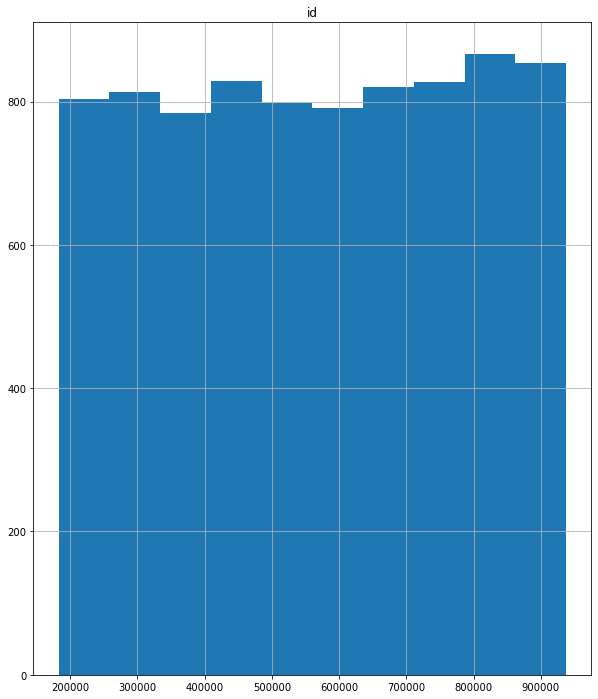

In [7]:
df.hist(figsize=(10,12));

In [8]:
df['action'].value_counts()

view     6328
click    1860
Name: action, dtype: int64

In [9]:
viewers = df[df['action'] == "view"]
viewers

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view
...,...,...,...,...
8183,2017-01-18 09:11:41.984113,192060,experiment,view
8184,2017-01-18 09:42:12.844575,755912,experiment,view
8185,2017-01-18 10:01:09.026482,458115,experiment,view
8186,2017-01-18 10:08:51.588469,505451,control,view


In [10]:
df['group'].value_counts().sum() == len(df)
control_group = df[df['group'] == 'control']
print(control_group.mean())
control_group

id    562817.716463
dtype: float64


,timestamp,id,group,action
3,2016-09-24 19:59:02.646620,671993,control,view
9,2016-09-24 21:00:12.278374,560027,control,view
23,2016-09-25 00:25:14.141290,281985,control,view
24,2016-09-25 01:14:48.603202,407864,control,view
25,2016-09-25 02:16:11.046654,342984,control,view
...,...,...,...,...
8178,2017-01-18 08:17:12.675797,616692,control,view
8181,2017-01-18 09:07:37.661143,795585,control,view
8182,2017-01-18 09:09:17.363917,795585,control,click
8186,2017-01-18 10:08:51.588469,505451,control,view


In [11]:
df['group'].value_counts().sum() == len(df)
experiment_group = df[df['group'] == 'experiment']
print(experiment_group.mean())
experiment_group


id    566744.854485
dtype: float64


,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
4,2016-09-24 20:26:14.466886,536734,experiment,view
5,2016-09-24 20:32:25.712659,681598,experiment,view
...,...,...,...,...
8179,2017-01-18 08:53:50.910310,615849,experiment,view
8180,2017-01-18 08:54:56.879682,615849,experiment,click
8183,2017-01-18 09:11:41.984113,192060,experiment,view
8184,2017-01-18 09:42:12.844575,755912,experiment,view


In [12]:
view_clickers= df[df['action'] == "click"]
view_clickers

,timestamp,id,group,action
8,2016-09-24 20:58:01.948663,349125,experiment,click
12,2016-09-24 21:06:27.553057,601714,experiment,click
15,2016-09-24 21:30:02.739756,487634,experiment,click
17,2016-09-24 23:01:12.108316,468601,experiment,click
21,2016-09-25 00:01:47.933853,555973,experiment,click
...,...,...,...,...
8162,2017-01-17 23:20:35.483601,451198,control,click
8164,2017-01-17 23:47:58.209653,252195,control,click
8167,2017-01-18 00:56:24.554729,344770,experiment,click
8180,2017-01-18 08:54:56.879682,615849,experiment,click


In [13]:
non_veiw_clickers = df[df['action'] == "click"] == df[df["action"] != "view"]
non_veiw_clickers.value_counts().sum()

1860

In [14]:
non_click_viewers = df[df['action'] == "view"] == df[df["action"] != "click"]
non_click_viewers.value_counts().sum()

6328

In [15]:
df['group'].value_counts().sum()

8188

In [16]:
df['group'].value_counts().sum() == len(df)

True

In [17]:
non_view_clickers = df[df['action'] == "click"] == df[df["action"] != "view"]
non_view_clickers.value_counts().sum()

1860

In [18]:
non_click_viewers = df[df['action'] == "view"].value_counts().sum() - non_view_clickers.value_counts().sum()
non_click_viewers

4468

In [19]:
cids = set(df[df.action=='click']['id'].unique())
vids = set(df[df.action=='view']['id'].unique())
print("Number of viewers: {} \tNumber of clickers: {}".format(len(vids), len(cids)))
print("Number of Viewers who didn't click: {}".format(len(vids-cids)))
print("Number of Clickers who didn't view: {}".format(len(cids-vids)))

Number of viewers: 6328 	Number of clickers: 1860
Number of Viewers who didn't click: 4468
Number of Clickers who didn't view: 0


## Conduct a Statistical Test

Conduct a statistical test to determine whether the experimental homepage was more effective than that of the control group.

In [20]:
#Your code here
df['group'].value_counts()

control       4264
experiment    3924
Name: group, dtype: int64

In [21]:
experiment_df = df[df["group"] == "experiment"]
control_df = df[df["group"] == "control"]
print(control_df['id'].mean())
print(experiment_df['id'].mean())

562817.7164634146
566744.8544852191


In [22]:
exp_df = df[df['group'] == 'experimental']
con_df = df[df['group'] == 'control']
exp_mean = exp_df['id'].mean()
con_mean = con_df['id'].mean()

In [23]:
H_0 = "There is no difference between the experimental homepage and the control group"
H_1 = "The experimental homepage was more effective than that of the control group"

print(f'H_0: {H_0}\nH_1: {H_1}')

H_0: There is no difference between the experimental homepage and the control group
H_1: The experimental homepage was more effective than that of the control group


In [24]:
df['count'] = 1
df.head()

,timestamp,id,group,action,count
0,2016-09-24 17:42:27.839496,804196,experiment,view,1
1,2016-09-24 19:19:03.542569,434745,experiment,view,1
2,2016-09-24 19:36:00.944135,507599,experiment,view,1
3,2016-09-24 19:59:02.646620,671993,control,view,1
4,2016-09-24 20:26:14.466886,536734,experiment,view,1


In [25]:
control = df[df.group=='control'].pivot(index='id', columns='action', values='count')
control = control.fillna(value=0)

experiment = df[df.group=='experiment'].pivot(index='id', columns='action', values='count')
experiment = experiment.fillna(value=0)



print("Sample sizes:\tControl: {}\tExperiment: {}".format(len(control), len(experiment)))
print("Total Clicks:\tControl: {}\tExperiment: {}".format(control.click.sum(), experiment.click.sum()))
print("Average click rate:\tControl: {}\tExperiment: {}".format(control.click.mean(), experiment.click.mean()))
control.head()

Sample sizes:	Control: 3332	Experiment: 2996
Total Clicks:	Control: 932.0	Experiment: 928.0
Average click rate:	Control: 0.2797118847539016	Experiment: 0.3097463284379172


action,click,view
id,,
182994,1.0,1.0
183089,0.0,1.0
183248,1.0,1.0
183515,0.0,1.0
183524,0.0,1.0


## Verifying Results

One sensible formulation of the data to answer the hypothesis test above would be to create a binary variable representing each individual in the experiment and control group. This binary variable would represent whether or not that individual clicked on the homepage; 1 for they did and 0 if they did not. 

The variance for the number of successes in a sample of a binomial variable with n observations is given by:

## $n\bullet p (1-p)$

Given this, perform 3 steps to verify the results of your statistical test:
1. Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 
2. Calculate the number of standard deviations that the actual number of clicks was from this estimate. 
3. Finally, calculate a p-value using the normal distribution based on this z-score.

### Step 1:
Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 

In [26]:
#Your code here
control_rate = control.click.mean()
expected_experiment_clicks_under_null = control_rate * len(experiment)
print(expected_experiment_clicks_under_null)


838.0168067226891


### Step 2:
Calculate the number of standard deviations that the actual number of clicks was from this estimate.

In [27]:
#Your code here
n = len(experiment)
p = control_rate
var = n * p * (1-p)
std = np.sqrt(var)
print(std)

24.568547907005815


In [28]:
actual_experiment_clicks = experiment.click.sum()
z_score = (actual_experiment_clicks - expected_experiment_clicks_under_null)/std
print(z_score)

3.6625360854823588


### Step 3: 
Finally, calculate a p-value using the normal distribution based on this z-score.

In [29]:
#Your code here
import scipy.stats as stats
p_val = stats.norm.sf(z_score) #or 1 - stats.norm.cdf(z_score)
print(p_val)

0.00012486528006951198


### Analysis:

Does this result roughly match that of the previous statistical test?

> Comment: # Comment: Yes, while the p-value is slightly lower, 
both would lead to confident rejection of the null hypothesis. 
The experimental page appears to be a more effective design.

## Summary

In this lab, you continued to get more practice designing and conducting AB tests. This required additional work preprocessing and formulating the initial problem in a suitable manner. Additionally, you also saw how to verify results, strengthening your knowledge of binomial variables, and reviewing initial statistical concepts of the central limit theorem, standard deviation, z-scores, and their accompanying p-values.

In [2]:
!pip install scipy